# Marketing Mix Model

**Sanofi**

-Author: Patricio Fernández

- Dependencies
    - Optuna library (for optimization).
    - Pandas
    - Matplotlib
    - Sklearn
    - Excel with data.

## Objective of this Notebook 

This notebook serves as a guide on how to build marketing mix models in order to obtain contributions of the different channels (touchpoints) on product sales. This toy example includes relevant feature transformations as adstock (decay), seasonality, saturation, lags, etc. 

This notebook also contains a very simple and quick optimization tool can serve as inspiration but should not be taken as a definite solution for the Turing use case. Likewise, it has been built with toy data which mimics real-life scenarios, but is not a full picture of the marketing spends a real product has during a year.

## 1. initialize notebook and load helpers

In [1]:
# Install optuna for non linear optimization. 
#!pip install optuna

In [2]:
# Imports.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression, Ridge
import optuna
from scipy.interpolate import make_interp_spline


In [3]:
# Configuration for viz and verbosity.
plt.rcParams["figure.figsize"] = (20,8)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [4]:
# Helpers
# Data process .

def process_pivoted_df(
    pdf_input: pd.DataFrame,
    aggregate: bool,
    old_col: list,
    new_col: str or list,
) -> pd.DataFrame:
    "Aggregate (optional) and daily resample a pivoted df"
    # Create a copy of input df.
    pdf = pdf_input.copy()
    # If we decide to aggregate subchannels, we sum selected columns.
    if aggregate:
        pdf[new_col] = pdf[old_col].sum(axis=1)
        pdf.drop(old_col, axis=1, inplace=True)
    else:
        rename_dict = {j:i for i, j in zip(new_col, old_col)} 
        pdf.rename(rename_dict, axis=1, inplace=True)
    # From weekly data into into a daily format.
    pdf = pdf.set_index('Date').resample('d').ffill()
    # Distributed monthly values across days.
    for c in pdf.columns:
        pdf[c] = pdf[c] / 7
    return pdf

def process_tabular_df(
    pdf_input: pd.DataFrame,
    filter: bool,
    col_to_agg: list,
    new_col: str,
) -> pd.DataFrame:
    "Aggregate, filter (optional) and daily resample a tabulated df"
    # Create a copy of input df.
    pdf = pdf_input.copy()
    # Since we work with COUGH products, we might want to filter per topic.
    if filter:
        pdf = pdf[pdf['Topic'] == 'COUGH']
    pdf = (pdf.groupby('Date')
              .agg({col_to_agg: 'sum'})
              .rename({col_to_agg: new_col}, axis=1))
    # From monthly data into into a daily format.
    pdf = pdf.resample('d').ffill()
    # Distributed monthly values across days.
    for c in pdf.columns:
        pdf[c] = pdf[c] / pdf.index.days_in_month
    return pdf

def add_monthly_seasonality(
    pdf_input: pd.DataFrame
) -> pd.DataFrame:
    "Adds monthly seasonality as one hot encoded variables"
    pdf = pdf_input.copy()
    # Create col for month.
    pdf['month'] = pd.to_datetime(pdf.index).month
    # Add one hot encoding. Remove last column due to redundancy.
    pdf_seasonal = pdf.join(
        pd.get_dummies(pdf['month'], prefix='month').iloc[:, :-1])
    return  pdf_seasonal.drop('month', axis=1)

# Carry over, Saturation helpers.

def carry_over_effect(
    input_variable: pd.Series, decay: float, lag: int
) -> pd.Series:
    "Apply carry over transformation to a given pandas Series"
    output = []
    for row in range(len(input_variable)):
        # Take care of observations with less days than required for lags. 
        # e.g. For the first day, we have a problem if lag=5.
        lag_aux = min(lag, row)
        
        # Apply decay effect to every row.
        output.append(
            sum(
                [
                    input_variable[row-i] * (decay ** i)  for i in range(lag_aux + 1)
                ]
            )
        )
    return pd.Series(output)

def saturation_effect(input_variable: pd.Series, alpha: float
) -> pd.Series:
    "Apply exponential transformation to a given pandas Series."
    return (1 - np.exp(-alpha * input_variable))

def adstock_tranformation(
    input_variable: pd.Series, alpha: float, decay: float, lag: int
) -> pd.Series:
    "Apply adstock transformation to a given pandas Series."
    return saturation_effect(carry_over_effect(input_variable, decay, lag), alpha)

def add_adstock_to_pdf(
    pdf_input: pd.DataFrame,
    hyperparameters: dict,
    channels: list,
) -> pd.DataFrame:
    "Add adstock columns to a given dataset."
    
    pdf = pdf_input.copy()
    # Add a column for each channel with the name adstock_channel.
    for c in channels:
        pdf[f'adstock_{c}'] = adstock_tranformation(
            pdf[c],
            hyperparameters[f'alpha_{c}'],
            hyperparameters[f'decay_{c}'],
            hyperparameters[f'lag_{c}']
            ).values
    return pdf

def sales_from(
    channel: str,
    features: list,
    model: LinearRegression,
    X: pd.DataFrame
    ) -> pd.DataFrame:
    "Compute sales attributed to a certain channel"
    coef = model.coef_[features.index(channel)]
    obs = X.iloc[:, features.index(channel)]
    return  coef * obs

# Response Curves Helpers

def build_response_curves_lr(
    model, 
    train_df: pd.DataFrame,
    original_features_df: pd.DataFrame,
    uplift_values: np.array,
    hyperparameters: dict
):
    """Builds response curves for the results of a linear modelling, levaring
    on what was obtained from the previous optimization iteration.

    Response curves are calculated based on mean spend given a set of uplifts
    and incremental sales.

    :param model: Model trained to make predictions.
    :type model: ANY
    :param train_df: Dataframe used to train the model.
    :type train_df: pd.DataFrame
    :param original_features_df: DataFrame with the original spend values.
    :type original_features_df: pd.DataFrame
    :param uplift_values: uplift values to multiply them to mean spend.
    :type uplift_values: np.array
    :param hyperparameters: optimized decay, lag and alpha values dictionary.
    :type hyperparameters: dict
    """
    features = [c for c in train_df.columns if c != TARGET]
    # Baseline sales if all are fixed to 0.
    # This can be addressed multiple ways, but this is a quick way to do it.
    # In the final version, every non-spend related feature should be accounted as baseline too.
    # This includes for example, seasonality. 
    base_sales = model.predict([np.zeros(len(features))])

    for c in train_df.columns:
        if "month" not in c:
            _data = pd.DataFrame(
            columns=train_df.columns,
            )
            # mean spend (with adstock) will be used to calculate incremental sales.
            _data[c] = train_df[c].mean() * uplift_values   
            _data.fillna(0, inplace=True)
            # Sales if only that channel is activated.
            # Again this would change depending on the method used to calculate baseline.
            ch_sales = model.predict(_data)
            incremental_sales = (ch_sales - base_sales)
            # Apply selected saturation to the incremental sales.
            incremental_sales = saturation_effect(
                incremental_sales, 
                hyperparameters[f"alpha_{c.replace('adstock_', '')}"
                ]
            )
            # Getting spend as mean * uplift values.
            x = original_features_df[
                    c.replace('adstock_', '')
                ].mean() * uplift_values
            plot_rc(x, incremental_sales, c)


def plot_rc(x: np.array, y: np.array, title: str = ""):

    # Plotting the Graph
    plt.plot(x, y, 'o-')
    plt.title(title)
    plt.xlabel(f"Spend")
    plt.ylabel("Incremental Sales (normalized)")
    plt.show()



## 2. Read data and define constants

In [5]:
# Path were the input file is stored.
excel_path = './CC Dataset.xlsx'

# Every sheet (5) will be a DataFrame.
xls = pd.ExcelFile(excel_path)
pdf_sales_1921 = pd.read_excel(xls, 'Sales 19-21')
pdf_sales_1718 = pd.read_excel(xls, 'Sales 17-18')
pdf_tv_input = pd.read_excel(xls, 'TV Spent')
pdf_promo_input = pd.read_excel(xls, 'PromotionalEvents')
pdf_onsite_trade_input = pd.read_excel(xls, 'OnsiteTrade')

In [6]:
# Define channels to use.
CHANNELS = ['tv_1', 'tv_2', 'tv_3', 'promo', 'onsite']

# Define target variable.
TARGET = 'sales'

# Define weeks for testing period.
TEST_SIZE = 24
# Define budget for allocation.
BUDGET = 1000  # To be used when optimization method is defined.
# Seed for reproducibility
SEED = 7

## 3. Process data

We have different sources of data with different formats.
Some of them are at weekly level, others at monthly level. For every marketing channel, we have multiple subchannels (for example, in TV there are 3 different subchannels and in promo events and on site trade, we encounter different locations and targets).

There's no single way to proceed and ideally we should check with our business partners our different assumptions.

The goal of this notebook is to have a minimal working example, so we will reduce the level of complexity as much as possible. For this, we decided to model our sales variable as a function of every tv subchannel, events and onsite marketing.

Also, we will assume that non cough promotional events have a marginal impact in cough sales, thus filtering them from our data.

Finally, we will work with weekly granularity, allocating promo events and onsite marketing evenly distributed for every week in the month.

In [7]:
# Processing tv data.
pdf_tv = process_pivoted_df(
    pdf_input=pdf_tv_input,
    aggregate=False,
    old_col=[f'Channel {i}' for i in range(1,4)],
    new_col=[f'tv_{i}' for i in range(1,4)],
)

# Processing promo events data.
pdf_promo = process_tabular_df(
    pdf_input=pdf_promo_input,
    filter=True,
    col_to_agg='Cost',
    new_col='promo',
)

# Processing on site marketing data. Obs: We don't have data for 2021, we will assume there were no investment.
pdf_onsite = process_tabular_df(
    pdf_input=pdf_onsite_trade_input,
    filter=False,
    col_to_agg='Value',
    new_col='onsite',
)

# Sales data.
pdf_sales = process_pivoted_df(
    pdf_input=pdf_sales_1921,
    aggregate=False,
    old_col=['Value'],
    new_col=[TARGET],
)

# Merge everything together.
pdf_merged = (
    pdf_sales
    .join(pdf_tv, how='left')
    .join(pdf_promo, how='left')
    .join(pdf_onsite, how='left')
).resample('w').sum()

# Adds OHE variables.
pdf_processed = add_monthly_seasonality(pdf_merged)
pdf_processed.head()

,sales,tv_1,tv_2,tv_3,promo,onsite,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
Date,,,,,,,,,,,,,,,,,
2019-01-13,2333.774722,605.0,125.0,37.381706,12.514645,1158.023548,1,0,0,0,0,0,0,0,0,0,0
2019-01-20,2140.697120,508.0,167.0,34.766218,12.514645,1158.023548,1,0,0,0,0,0,0,0,0,0,0
2019-01-27,2485.883420,0.0,166.0,46.756001,12.514645,1158.023548,1,0,0,0,0,0,0,0,0,0,0
2019-02-03,2777.820794,0.0,191.0,47.218405,8.999762,1138.811742,0,1,0,0,0,0,0,0,0,0,0
2019-02-10,2875.494071,0.0,158.0,44.303406,4.313250,1113.196000,0,1,0,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='Date'>

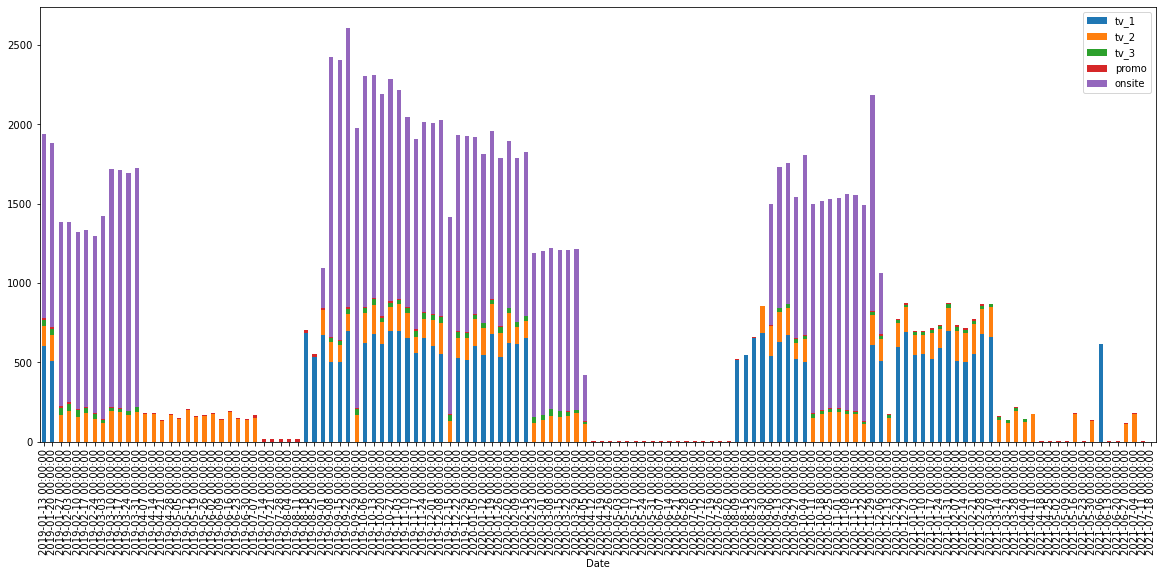

In [8]:
# Quickly check spend values 

pdf_processed.loc[:, CHANNELS].plot(kind='bar', stacked=True)

## 4. Adstock modeling.

In this section we add (i) carry over and (ii) saturation effects.

We want to model the relationship of the different investment channels using a linear regression, however we want to take into account the [decay effect](https://en.wikipedia.org/wiki/Advertising_adstock#Advertising_lag:_decay_effect) and the [law of diminishing returns](https://en.wikipedia.org/wiki/Advertising_adstock#Campaign_carry-over).

---
For this, instead of working directly with spend per channel, we apply different transformations to them

> 1. For carry over $c_{t}$, we apply the following transformation.
$$c_{t} = x_{t} + \sum_{j=1}^{n} \lambda^{t}  x_{t-j}$$
>
> Where $x_{t}$ is the investment in the channel for the $t$ period, $n$ represents the amount of periods to look back and $\lambda$ represents the strength or decay factor. Both $n$ and $\lambda$ will be parameters of the function.
><br/>
><br/>
>2. For the saturation effect $s_{t}$, the following transformation is applied.
>
>$$s_{t} =1 -  e^{-\alpha x_{t}} $$
>
> In this case, $\alpha$ will be a parameter to input.

<br/>

In consequence, instead of modeling sales as a function of investment per channel, we fit a regression to the transformations described previously. The question now is which values should we use for **$n$, $\lambda$ and $\alpha$**? We can think of them as *hyperparameters of our model*. And then perform a *numerical optimization* to find values that minimize the mean squared error (or any metric of our interest) of the model.
<br/>


Lastly, data presents a heavy seasonality, one hot encoded variables were added for every month in the year.

---

For a complete explanation of the methods used in here, we refer the reader to page *154/510* of [Introduction to Algorithmic Marketing](https://algorithmicweb.files.wordpress.com/2018/07/algorithmic-marketing-ai-for-marketing-operations-r1-7g.pdf).


## 5. Fit model.

### Tune hyperparameters

- We use optuna for hyperparameter tuning, but other libraries like `scipy.minimize` should work as well.
- For every channel, we have three ($\alpha$, $n$ and $\lambda$) hyperparameters to tune.
- We work with a Ridge regression to account for (possible) overfitting.
- We aim to minimize *MSE*.
- We repeat 2000 trials for the optimization, caution! can take some time. Feel free to change `n_trials=100` to speed things up.
- We split the dataset in train and test. Since we are working with time series we work with consecutives chunks of data. We define `test_size=24` weeks

In [9]:
# Split data for train test.
pdf_train = pdf_processed.iloc[:-TEST_SIZE, :]
pdf_test = pdf_processed.iloc[-TEST_SIZE:, :]

# Define features and target variable.
features = [
    c for c in list(pdf_processed) if 'month' in c
] + [f'adstock_{c}' for c in CHANNELS]

In [10]:
# Usually helpers should be at the top of the notebook, but we put this one here
# as it is a dictionary with multiple values to configure and play around with.

def objective_tune_params(trial, df: pd.DataFrame = pdf_train):

    hyperparameters = {
        'alpha_tv_1': trial.suggest_float('alpha_tv_1', 0, 0.1),
        'decay_tv_1': trial.suggest_float('decay_tv_1',  0, 0.5),
        'lag_tv_1': trial.suggest_int('lag_tv_1', 0, 6),
        'alpha_tv_2': trial.suggest_float('alpha_tv_2', 0, 0.1),
        'decay_tv_2': trial.suggest_float('decay_tv_2',  0, 0.5),        
        'lag_tv_2': trial.suggest_int('lag_tv_2', 0, 6),
        'alpha_tv_3': trial.suggest_float('alpha_tv_3', 0, 0.1),
        'decay_tv_3': trial.suggest_float('decay_tv_3',  0, 0.5),
        'lag_tv_3': trial.suggest_int('lag_tv_3', 0, 6),
        'alpha_onsite': trial.suggest_float('alpha_onsite', 0, 0.1),
        'decay_onsite': trial.suggest_float('decay_onsite', 0, 0.5),
        'lag_onsite': trial.suggest_int('lag_onsite', 0, 3),
        'alpha_promo': trial.suggest_float('alpha_promo', 0, 0.1),
        'decay_promo': trial.suggest_float('decay_promo', 0, 0.5),
        'lag_promo': trial.suggest_int('lag_promo', 0, 5)
    }
    # Add adstock variables
    pdf_adstock = add_adstock_to_pdf(df, hyperparameters, CHANNELS)

    # Define X and y.  
    X = pdf_adstock[features]
    y = pdf_adstock[TARGET]
    
    # Initialize regression class.
    lr = Ridge()
    # lr = LinearRegression()
    
    # Fit model and compute error (mean squared error).
    lr.fit(X ,y)
    y_hat = lr.predict(X)
    return np.mean((y - y_hat) ** 2)

In [11]:
# Perform the optimization.
study_tune_params = optuna.create_study(
    sampler=optuna.samplers.RandomSampler(seed=SEED)
)
study_tune_params.optimize(objective_tune_params, n_trials=1000)

### Run final model.
With tuned hyperparameters, we train the final model.

In [12]:
# Check optimized params.
study_tune_params.best_params

{'alpha_tv_1': 0.04690602490550662,
 'decay_tv_1': 0.30237634400064495,
 'lag_tv_1': 4,
 'alpha_tv_2': 0.08539613854242417,
 'decay_tv_2': 0.11043462562125772,
 'lag_tv_2': 1,
 'alpha_tv_3': 0.017023272396868582,
 'decay_tv_3': 0.44047188722759706,
 'lag_tv_3': 3,
 'alpha_onsite': 0.00476263666735286,
 'decay_onsite': 0.3979564725494709,
 'lag_onsite': 0,
 'alpha_promo': 0.024652355366524437,
 'decay_promo': 0.10561578744525785,
 'lag_promo': 2}

In [13]:
# Best set of hyperparameters.
hyperparameters = study_tune_params.best_params

# We replicate adstock transformation, train test splitting and model fitting. 
# Add adstock columns. 
pdf_adstock_train  = add_adstock_to_pdf(pdf_train,hyperparameters, CHANNELS) 
pdf_adstock_test = add_adstock_to_pdf(pdf_test, hyperparameters, CHANNELS)

# Define train and test data.
X_train, y_train = pdf_adstock_train[features], pdf_adstock_train[TARGET]
X_test, y_test = pdf_adstock_test[features], pdf_adstock_test[TARGET]

# Initialize model.
lr = Ridge()

lr.fit(X_train, y_train)

Ridge()

## 6. Model performance.

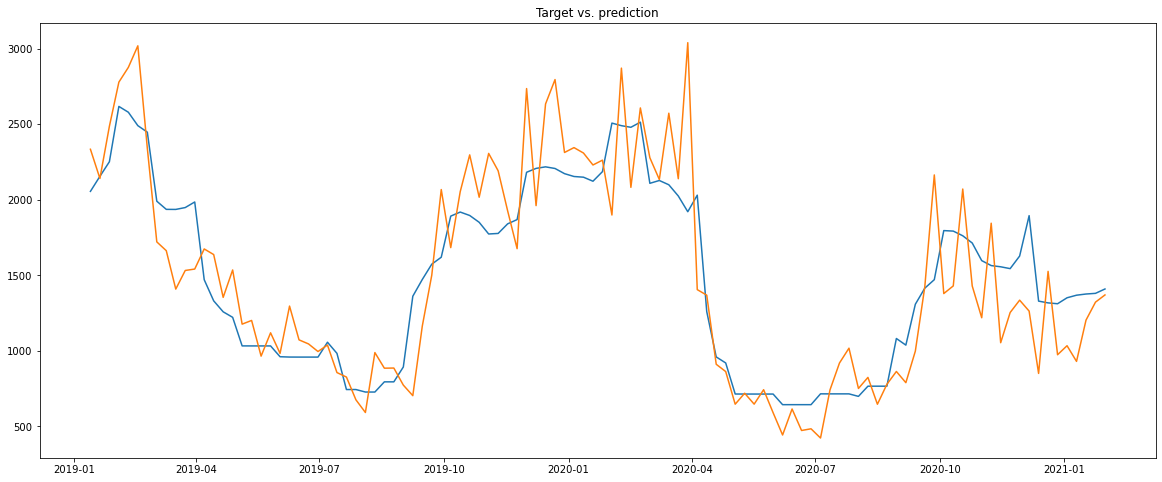

MAPE for training period is:0.18
MAPE for testing period is:0.22


In [14]:
# Line chart for performance.
plt.plot(pdf_train.index, lr.predict(X_train),
         pdf_train.index, y_train)
plt.title('Target vs. prediction')
plt.show()

# Compute mean absolute error.
# Actually, we should check for mse since it's what we are optimizing for. 
# However, mape might be a bit more intuitive.
mape_train = np.mean(
    np.abs((y_train - lr.predict(X_train))) / y_train
)
mape_test = np.mean(
    np.abs((y_test - lr.predict(X_test))) / y_test
)

print(f'MAPE for training period is:{np.round(mape_train, 2)}')
print(f'MAPE for testing period is:{np.round(mape_test, 2)}')

## 7. Channel contribution.

We observe the marginal channel contribution and the return on investment per channel.

- on site marketing, tv_2 and tv_3 are the biggest sales drivers.
- tv_3 and promotional events seems to be the two most efficients channels.
- tv_1 and on site marketing seems to be inneficient channels (ROI < 1).

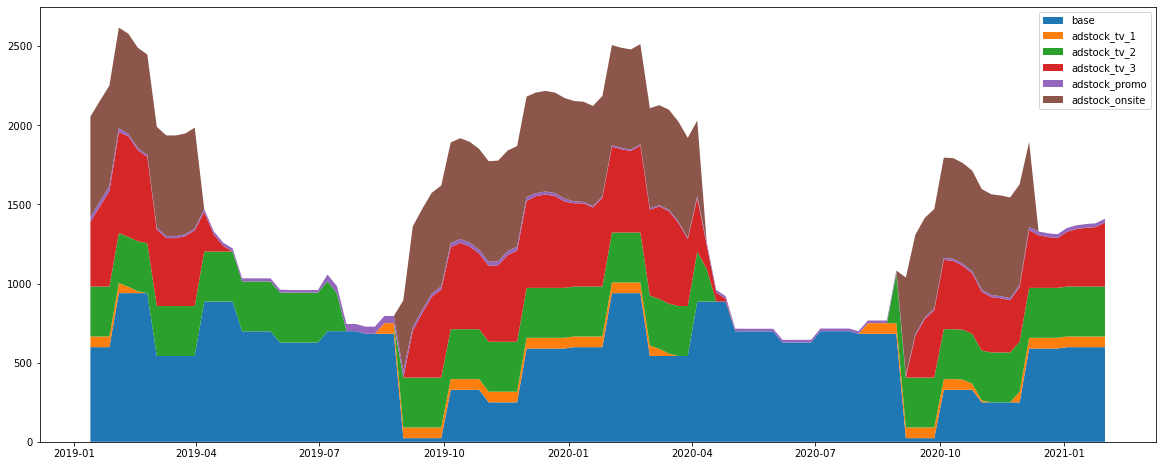

For adstock_tv_1: share of total sales is 0.02 and ROI is 0.14
For adstock_tv_2: share of total sales is 0.16 and ROI is 2.07
For adstock_tv_3: share of total sales is 0.19 and ROI is 17.1
For adstock_promo: share of total sales is 0.01 and ROI is 2.77
For adstock_onsite: share of total sales is 0.23 and ROI is 0.53


In [15]:

# base sales takes into account the intercept plus monthly effects.
base = (
    sum(
        [
            lr.coef_[features.index(c)] * X_train.iloc[:, features.index(c)] for c in features if 'month' in c
        ]
    )
      + [lr.intercept_] * len(pdf_train.index))

plt.stackplot(pdf_train.index,base,
              sales_from('adstock_tv_1', features, lr, X_train),
              sales_from('adstock_tv_2', features, lr, X_train),
              sales_from('adstock_tv_3', features, lr, X_train),
              sales_from('adstock_promo', features, lr, X_train),
              sales_from('adstock_onsite', features, lr, X_train)
              )
plt.legend(['base'] + [c for c in features if 'month' not in c])
plt.show()

# Compute ROI for every channel.
for c in features:
    if 'month' not in c:
        channel_share = np.round(sum(sales_from(c, features, lr, X_train)) / sum(lr.predict(X_train)), 2)
        channel_roi = np.round(sum(sales_from(c, features, lr, X_train)) / sum(pdf_adstock_train[c.replace('adstock_', '')]), 2)
        print(f'For {c}: share of total sales is {channel_share} and ROI is {channel_roi}')

## 8. Response Curves

There are multiple ways of calculating response curves and depending on where you search, one method or another might be displayed.
I personally think the most useful method shows the relationship between uplift and incremental gains. For example having incremental spend (discretized) on the X axis, and incremental sales on the Y axis. 


### Spend Uplift vs Incremental Sales

Fitting uplift curves with linear models is not fully feasible as the relationships are linear, which means that when plotted, the result will be a straight diagonal line. We can have a workaround using the saturation values we have calculated before. This method "mimics" what you can achieve from using Bayesian models, where
you optimize on shape, decay and saturation too. However, this method has major limitations, hence the results should be taken with caution.

**ATTENTION!**: Given how the data is distributed, it will be better to use total spend per year (or n amount of months) instead of mean spend. This might give the idea that we are currently spending around the mean on a weekly basis, but data shows that there are multiple "off" periods where a channel has no spend at all.

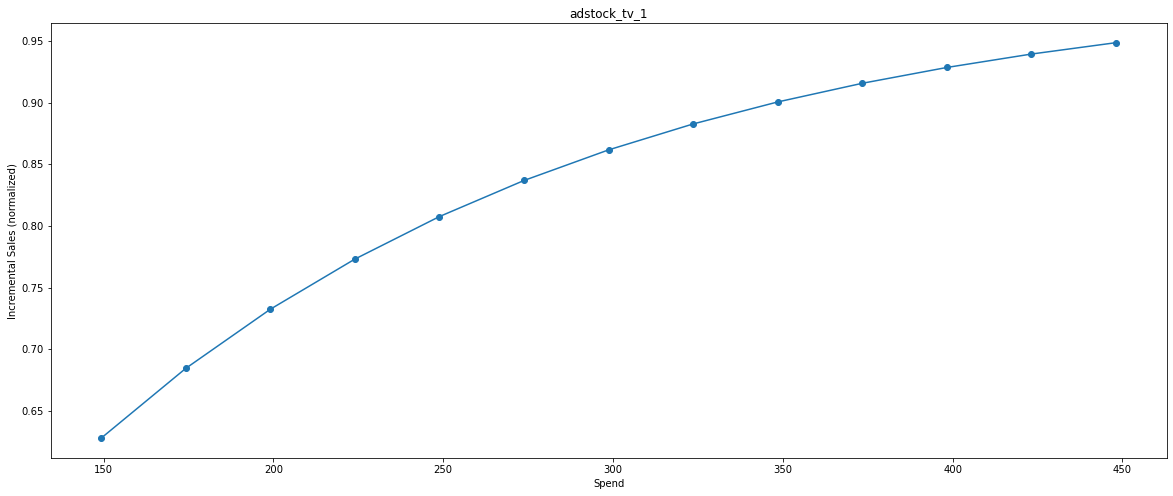

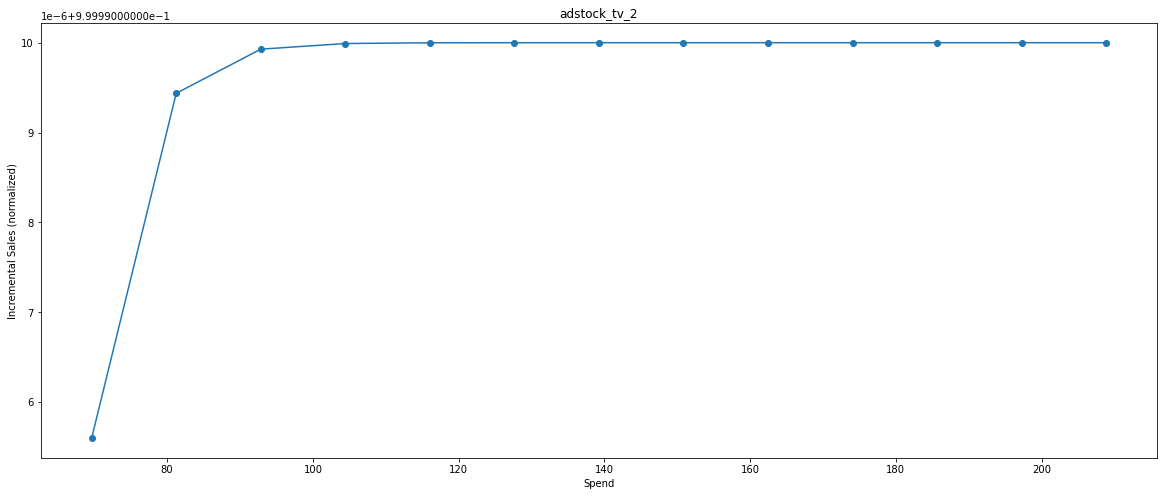

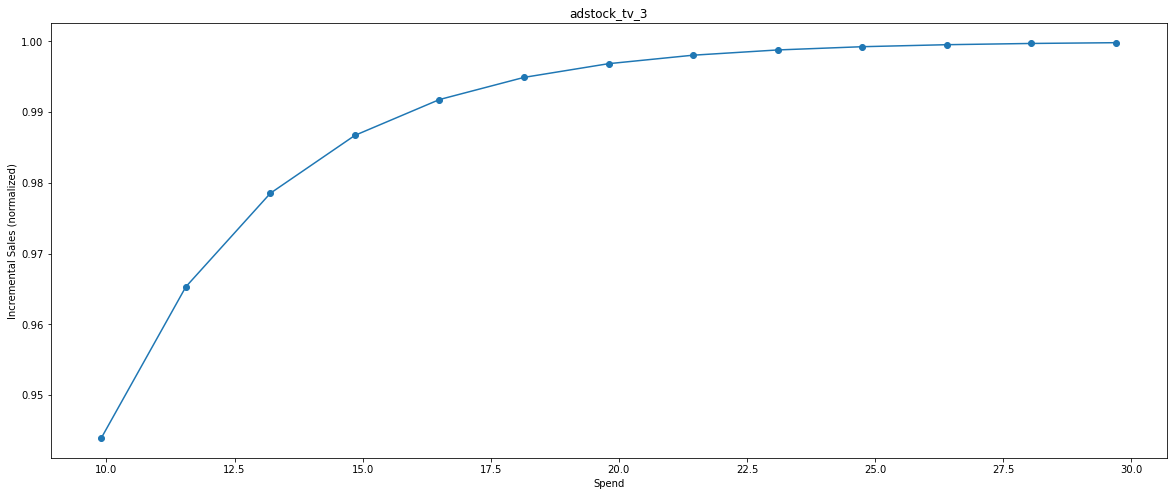

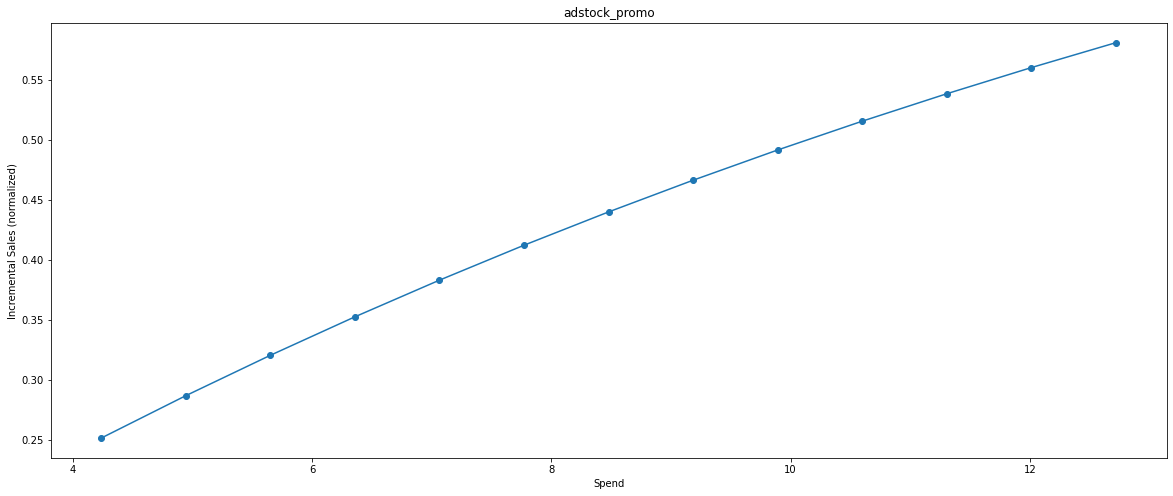

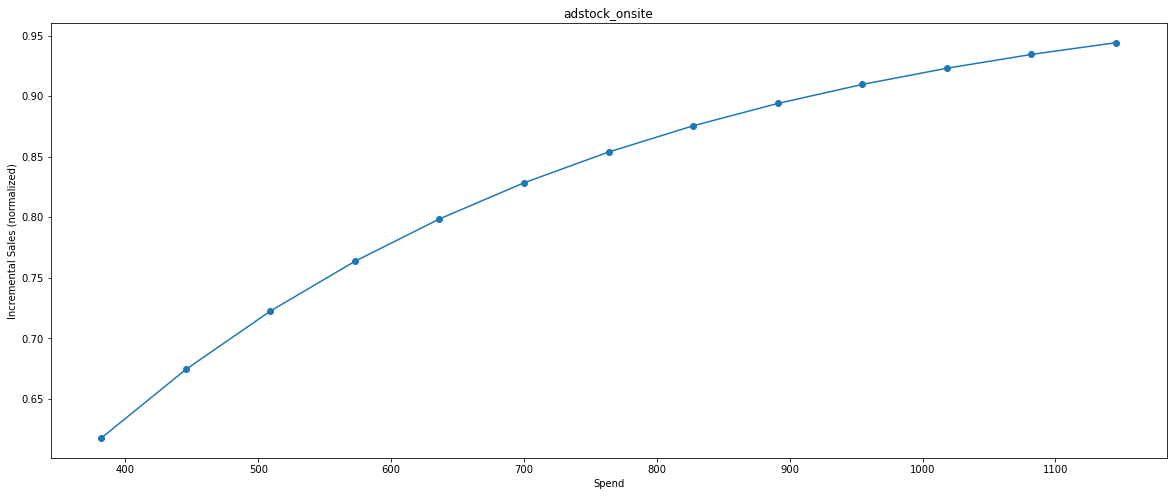

In [20]:
uplift_vals = np.arange(0.6, 1.8, 0.1)
build_response_curves_lr(lr, X_train, pdf_adstock_train, uplift_vals, hyperparameters)

## 8. Budget Allocation.

Leveraging the response curves, we can optimize with them WIP (method to be defined)